# Cloud points view of a mesh

So Christophe Leterier[@christlet](https://twitter.com/christlet) and Felix Voilzel [@Flexi23](https://twitter.com/Flexi23) made this:

<blockquote class="twitter-tweet" data-partner="tweetdeck"><p lang="en" dir="ltr">I gave data to <a href="https://twitter.com/Flexi23">@Flexi23</a> and he developed... a SMLM 3D viewer in your web browser! This is excellencredible <a href="https://t.co/pTqUGlXVV6">pic.twitter.com/pTqUGlXVV6</a></p>&mdash; Christophe Leterrier (@christlet) <a href="https://twitter.com/christlet/status/791642533059293184">October 27, 2016</a></blockquote>
<script async src="//platform.twitter.com/widgets.js" charset="utf-8"></script>

Now I have to try to generate a point cloud along the edges to simulate STORM images.

### Loading a tyssue dataset 

In [1]:
import pandas as pd
import numpy as np

from tyssue.io import hdf5
from tyssue import config
from tyssue.core.monolayer import Monolayer

import matplotlib.pyplot as plt
%matplotlib qt
import seaborn as sns

In [21]:
datasets = hdf5.load_datasets('small_ellipsoid.hf5',
                              data_names=['vert', 'edge',
                                          'face', 'cell'])
specs = config.geometry.bulk_spec()

monolayer = Monolayer('ell', datasets, specs)
monolayer.reset_index()
monolayer.reset_topo()


## Generating particles from the edges


The idea is to simulate a STORM experiment, assuming our fluorophore is distributed along the edges.

Given the edge from the vertex at $\mathbf{r}_i$ to the one at $\mathbf{r}_j$, the possible positions of the particles are given by:

$$\mathbf{u}(s_{ij}) = \mathbf{r}_i + \mathbf{r}_{ij} \frac{s_{ij}}{\ell_{ij}}, \quad s \in (0, \ell_{ij})$$

Let $\delta_s$ be the spacing between two fluorphores, then we have $n_{ij} = \ell_{ij}/\delta_s$ fluorophores per edge.  
 

In [42]:
mean_length = monolayer.edge_df.length.mean()
delta_s = 0.1 * mean_length

mesh = monolayer.edge_df[['length',] + monolayer.dcoords].copy()
mesh['num_particles'] = (monolayer.edge_df.length/delta_s).astype(np.int)
real_edge_length = 1000 #in nm

points = pd.DataFrame(np.zeros((n_points, 3)), 
                      columns=monolayer.coords)

curv_indexer = np.repeat(np.arange(mesh.shape[0]), 
                         mesh['num_particles'])


ramps = np.concatenate([np.linspace(0, 1, ns) 
                        for ns in mesh['num_particles']])

srce_pos = monolayer.upcast_srce(
        monolayer.vert_df[monolayer.coords]).loc[curv_indexer]

for c in monolayer.coords:
    points[c] = (srce_pos[c].values + ramps *
                 mesh['d'+c].loc[curv_indexer].values)

assert curv_indexer.max() + 1 == mesh.shape[0]

print('N edges: {}, N points: {}'.format(mesh.shape[0],
                                         curv_indexer.shape[0]))


real_edge_length = 1000 #in nm

points = points * real_edge_length 


N edges: 1656, N points: 15722


Add some noise to the mix

In [43]:
pos_noise = 5

pos_noise = np.random.normal(scale=pos_noise, size=(points.shape[0], 3))
points[monolayer.coords] += pos_noise

In [44]:

points.head()

,x,y,z
0,516.078950,-40.701994,-980.388579
1,527.170212,-2.685166,-981.413619
2,536.493926,36.821775,-985.948823
3,552.630076,70.987037,-978.715100
4,560.248958,106.333479,-965.580117


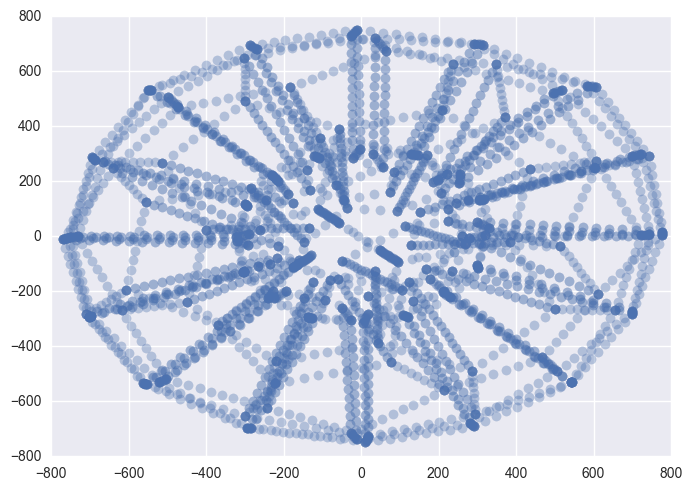

In [35]:
fig, ax = plt.subplots()
ax.plot(*points[['x', 'y']].T.values, 'o', alpha=0.1)
fig

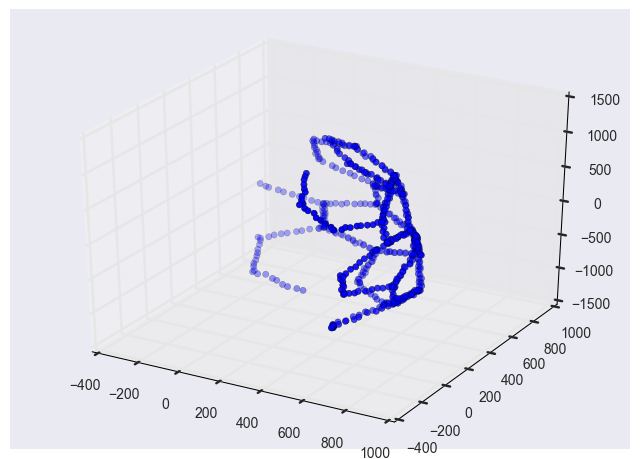

In [41]:
from mpl_toolkits.mplot3d import Axes3D


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

xs, ys, zs = points[monolayer.coords].values[:600].T
ax.scatter(xs, ys, zs)
fig

### The 3D Storm format

In [8]:
ls ../tyssue/visualisation/

3D_STORM_format.png  Visualization.ipynb


![Crop of the 3D_STORM format in a tabulator](../tyssue/visualisation/3D_STORM_format.png)

In [53]:
columns = ['frame', 'x [nm]', 'y [nm]', 'z [nm]',
           'uncertainty_xy', 'uncertainty_z']
storm_points = pd.DataFrame(np.zeros((points.shape[0], 6)), 
                            columns=columns)

storm_points[['x [nm]', 'y [nm]', 'z [nm]']] = points[monolayer.coords]
storm_points['frame'] = 1
storm_points[['uncertainty_xy', 'uncertainty_z']] = 2.1

storm_points.dropna().to_excel('ellipsoid_points.xls')


In [51]:
!ls -lh

total 3,9M
-rw-r--r-- 1 guillaume guillaume 114K août  24 18:09 ballon.obj
-rw-r--r-- 1 guillaume guillaume 8,1K août  24 18:09 before.png
drwxr-xr-x 2 guillaume guillaume 4,0K août  24 18:09 core_architecture
drwxr-xr-x 2 guillaume guillaume 4,0K sept.  7 09:26 dynamics
-rw-r--r-- 1 guillaume guillaume 110K oct.  27 22:15 ellipsis.png
-rw-r--r-- 1 guillaume guillaume 499K sept. 23 14:23 ellipsoid.blend
-rw-r--r-- 1 guillaume guillaume 7,7K oct.  27 22:15 Ellipsoid.ipynb
-rw-r--r-- 1 guillaume guillaume  33K oct.  27 22:15 ellipsoid.obj
-rw-r--r-- 1 guillaume guillaume  24K sept. 23 14:23 ellipsoid.png
-rw-r--r-- 1 guillaume guillaume 1,8M oct.  27 23:02 ellipsoid_points.xls
-rw-r--r-- 1 guillaume guillaume  32K août  24 18:09 generation.ipynb
drwxr-xr-x 3 guillaume guillaume 4,0K oct.  27 22:15 leg_joint
drwxr-xr-x 2 guillaume guillaume 4,0K août  24 18:09 leg_joint import
-rw-r--r-- 1 guillaume guillaume 642K oct.  27 23:01 Particles export.ipynb
drwxr-xr-x 2 guillaume guillaume 4,0K

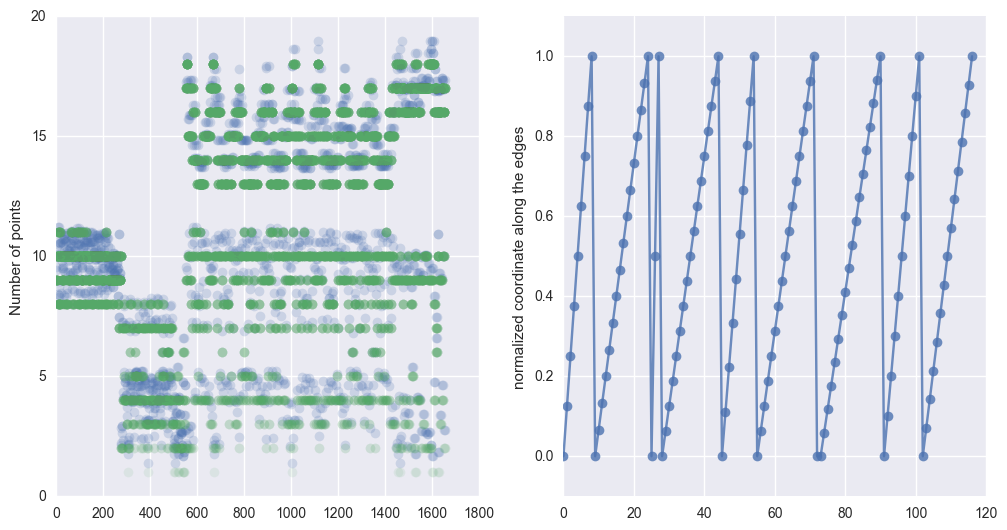

In [16]:
fig, (ax0, ax1) = plt.subplots(1, 2)

ax0.plot(mesh.length.values/delta_s, 'o', alpha=0.2)
ax0.plot(upcast_nij, 'o', alpha=0.1)
ax0.set_ylabel('Number of points')

e_start, e_stop = 1000, 1010

p_start, p_stop = (curv_indexer[curv_indexer < e_start].size,
                   curv_indexer[curv_indexer < e_stop].size )

ax1.plot(ramps[p_start: p_stop], '-o', alpha=0.8)
ax1.set_ylim(-0.1, 1.1)
ax1.set_ylabel('normalized coordinate along the edges')

fig.set_size_inches((12, 6))
fig